<a href="https://colab.research.google.com/github/othmane42/defi1_hackAI/blob/main/Classification83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [ ]:
# ?????????????????????????????????????
# ?????????????????????????????????????

# **2. Importation des librairies**

In [16]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2 
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
import math
from PIL import Image
#from google.colab import files
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

Tensorflow version: 2.8.0
Keras version: 2.8.0


#**3. Téléchargement des données d'entrainement "Small Dataset"**

In [2]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [3]:
!rm -rf sample_data
! wget --no-check-certificate https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_3.tar
! tar xf FIRE_DATABASE_3.tar -C 'bases' --one-top-level


--2022-11-25 09:06:42--  https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_3.tar
Resolving cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)... 193.190.209.220
Connecting to cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 471111680 (449M) [application/octet-stream]
Saving to: ‘FIRE_DATABASE_3.tar’

FIRE_DATABASE_3.tar 100%[===================>] 449.29M  14.1MB/s    in 34s     

2022-11-25 09:07:19 (13.1 MB/s) - ‘FIRE_DATABASE_3.tar’ saved [471111680/471111680]



In [ ]:
!mv bases/FIRE_DATABASE_3 bases/DB3

#**4. Téléchargement des données de test "Test Dataset"**

In [4]:
!rm -rf sample_data
!wget --no-check-certificate http://195.154.53.219/downloads/test.tar
! tar xf test.tar -C 'bases' --one-top-level
! rm test.tar

--2022-11-25 09:07:21--  http://195.154.53.219/downloads/test.tar
Connecting to 195.154.53.219:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58196480 (56M) [application/octet-stream]
Saving to: ‘test.tar’

test.tar            100%[===================>]  55.50M  14.1MB/s    in 5.0s    

2022-11-25 09:07:26 (11.0 MB/s) - ‘test.tar’ saved [58196480/58196480]



#**5. Création du fichier de labels "classes.txt"**

In [5]:
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

#**6. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [32]:
nb_classes = 3
batch_size=8 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=20 #@param [5, 10,20,50,100,200] {type:"raw"}
dataset_path = "bases3"
input_dim=224 #@param [224,299] {type:"raw"}  
dataset_name='FIRE_DATABASE_3' #@param ["small","DB1","DB2","DB3"]
train_dataset = os.path.join('bases3/', dataset_name)
test_name='test' #@param ["test","test1","test2","test3"]
test_dataset = os.path.join('bases/', test_name)
classes_path = "classes.txt"
classifier = "Xception" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}


# **7. Compter le nombre de classes**

In [33]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Création du jeu de données d'entraînement  (A COMPLETER)**

In [34]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.2,1],
        fill_mode='nearest',
        vertical_flip=False,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)


# this is the augmentation configuration we will use for testing:
# only rescaling
#test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dataset,  # this is the target directory
        target_size=(input_dim,input_dim),  # all images will be resized to 150x150
        batch_size=batch_size,
        seed=42,
        subset="training",
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = train_datagen.flow_from_directory(
        train_dataset,
        target_size=(input_dim,input_dim),
        seed=42,
        subset="validation",           # Sélection du jeu de données d'entraînement
        batch_size=batch_size,
        class_mode='categorical')

Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [35]:
input_dim

224

# **10. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [44]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50
from keras.applications.resnet_v2 import  ResNet152V2, ResNet50V2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
#from keras.applications import MobileNetV2
from keras.applications.densenet import DenseNet201
from keras import activations

#base_model = MobileNet(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))
#base_model = InceptionV3(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))
#base_model = MobileNetV2(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))
#base_model = ResNet152V2(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))
base_model = VGG16(include_top=False,weights="imagenet",input_shape=(input_dim,input_dim,3))

for layer in base_model.layers:
  layer.freeze=True

x=base_model.output
x=GlobalAveragePooling2D()(x)

x= Dense(128,activation="relu")(x)

y = Dense(nb_classes,activation="softmax")(x)

model = Model(inputs=base_model.input,outputs=y)

# **11. Geler puis dégeler les poids des premières couches**

In [ ]:
model.summary()

# **11. Compiler le modèle avec la descente de gradient stochastique DSG**


In [45]:
# recompiler le modèle
model.compile(loss="CategoricalCrossentropy",optimizer="adam",metrics=["accuracy"])
 

# **12. Entraîner le modèle**

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#seed_everything()
#tf.config.experimental.enable_op_determinism()

#model_cp = ModelCheckpoint("/content/drive/MyDrive/MyModels/groupe_15_21-11.h5",monitor="val_accuracy",save_best_only=True,verbose=1)

model_cp = ModelCheckpoint("groupe_15_25_11_db3.h5",monitor="val_accuracy",save_best_only=True,verbose=1)


early_stopping = EarlyStopping(monitor="val_accuracy",patience=10)

history=model.fit(train_generator,validation_data=validation_generator,epochs=25,callbacks=[model_cp,early_stopping],shuffle=False)


Epoch 1/25
150/150 [==============================] - ETA: 0s - loss: 4.2071 - accuracy: 0.5017
Epoch 1: val_accuracy improved from -inf to 0.63000, saving model to groupe_15_25_11_db3.h5
150/150 [==============================] - 35s 228ms/step - loss: 4.2071 - accuracy: 0.5017 - val_loss: 0.7680 - val_accuracy: 0.6300
Epoch 2/25
150/150 [==============================] - ETA: 0s - loss: 0.8612 - accuracy: 0.6175
Epoch 2: val_accuracy did not improve from 0.63000
150/150 [==============================] - 31s 205ms/step - loss: 0.8612 - accuracy: 0.6175 - val_loss: 1.1116 - val_accuracy: 0.5767
Epoch 3/25
150/150 [==============================] - ETA: 0s - loss: 0.7504 - accuracy: 0.6642
Epoch 3: val_accuracy improved from 0.63000 to 0.63333, saving model to groupe_15_25_11_db3.h5
150/150 [==============================] - 31s 207ms/step - loss: 0.7504 - accuracy: 0.6642 - val_loss: 0.7927 - val_accuracy: 0.6333
Epoch 4/25
150/150 [==============================] - ETA: 0s - loss: 0.

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [ ]:
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

#**14. Afficher des courbes d'entrainement/validation**

In [ ]:
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

# **15. Créer le jeu de données de test**

In [ ]:
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

# **16. Evaluer le modèle avec ce jeu de données de test**

In [ ]:
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????
#?????????????????????????????????????????????????

#**16. Tester le modèle avec une image de test: "fire.jpg" et "no_fire.jpg (A COMPLETER)"**

In [ ]:
files.upload()

In [17]:
train_generator.classes

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [18]:
classes

['fire', 'no_fire', 'start_fire']

1/1 [==============================] - 5s 5s/step
Class Name : fire --- Class Probability: 0.10%
Class Name : no_fire --- Class Probability: 0.77%
Class Name : start_fire --- Class Probability: 99.13%


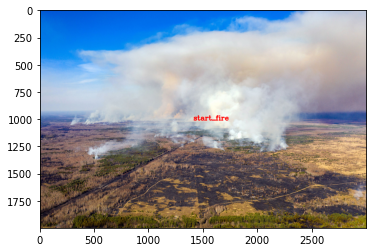

In [21]:
%matplotlib inline

image_path =  "./bases/test/start_fire/test101.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()